# Connect Four Reinforcement Learning Project

With this project, I aim to build a machine learning model that can play and win a game of Connect Four. To do this, I intend to use a reinforcement learning framework to train the model to recognize the correct move to make at each turn in the game.

Connect Four is a 2-player board game with simpe rules.  The board is a 6x7 grid (six rows, seven columns) that stands upright.  Both players take turns placing their pieces, which are marked with different colors, into the columns of the board.  Since the board stands upright, when a player places his or her piece into a column, the piece falls down to fill the bottommost empty slot.  The goal of the game is to place your pieces such that they form a straight line of four adjacent pieces; the line can be vertical, horizontal, or diagonal.

I used to play this game a lot when I was about 10 years old, and from what I remember of playing the game, the first few moves tend to involve some randomness and "creativity," but specific strategies take over as the board takes shape.  For example, later in the game, it is smart to place your pieces to "block" your opponent from creating a "run" of 3 pieces.  As another example, it is good strategy to try and create two "runs" of three pieces, either of which can be played on for a win -- and to prevent your opponent from doing the same.

## Creating the game environment

The first stage of this project is to build a Python function, `play_game()` that plays a game of Connect Four with two opponents making random placements on each turn.  Numpy's base `NDArray` class is an ideal tool to use to model the game board and its evolution over the course of the game.  Below are a number of helper functions that `play_game()` will call over the course of a game.

In [1]:
import numpy as np

The classic Connect Four game is played on a 6x7 grid.  I will set these dimensions here so that I can pass them through my `play_game()` function, and leave open the possibility of modifying them in the future.

In [2]:
b_d = (6, 7)
# diagnosic_board = np.arange(b_d[0]*b_d[1]).reshape(b_d)

As a first step, initialize an empty board, represented by an Numpy `NDArray` of zeros.  The number zero will represent an empty slot in the board.

In [3]:
def make_board(board_dim):
    """
    Initialize empty board with passed dimensions.
    """
    board = np.zeros(board_dim)
    return board

The `make_choice()` function serves to generate the chosen placement of a player.  At any point in the game, a player has 7 possible moves (potentially fewer, actually, since as the game progresses the columns get filled so they cannot hold any more pieces).  At first, I will model a player's choice with a simple random draw between the seven columns.  Later, I want to pass a prediction model to the function to allow a player to predict what to do by maximizing the expected "reward," given the current board state.  In either case, whether making a random choice or a predicted choice, the function returns an integer corresponding to the column number where the player will place his or her piece.

In [4]:
def make_choice(model, board):
    """
    If no prediciton model is passed,
    return a random choice of column to place a piece.
    Otherwise, use the model to choose the column with 
    the highest predicted reward.
    """
    if not model:
        choice = np.random.randint(0, 7)
    else:
        choice = predict_choice(model, board)
    return choice

The `predict_choice()` function is called when a player is using a model to predict the best move (as opposed to making a random move).  The function takes the prediction model and the current board state, and returns the move (column number) with the corresponding highest predicted "reward."

In [5]:
def predict_choice(model, board):
    """
    Return predictions of reward for each column.
    Return the choice with the highest predicted reward.
    """
    flat_board = board.flatten()
    X_pred = np.zeros((7, 43))
    for i in range(7):
        X_pred[i][0] = i
        for j in range(len(flat_board)):
            X_pred[i][j+1] = flat_board[j]
    X = pd.DataFrame(X_pred)
    y_hat = model.predict(X)
    return np.argmax(y_hat)

In Connect Four, a piece is placed by choosing a column, after which the piece occupies the current bottommost empty slot for the rest of the game.  In meatspace, this is done by dropping a piece (token) into the upright game board, and letting the piece fall down so that it either rests on the bottommost row, or on top of another piece.  In this simulation, the `place_token()` function finds the correct landing place of the token by finding the bottomost empty cell in the `NDArray` (represented by a zero) and changes the state of that cell to the player's token.  A token placed by player 1 is represented by a 1, and a token placed by player 2 is represented by a 2.

In [6]:
def place_token(board, choice, player_number):
    """
    Simulate the effect of gravity when placing a piece.
    Searches for the bottommost empty slot in the given column,
    and returns the updated board state.
    """
    placed = False
    while not placed:
        for row in range(board.shape[0]-1, -1, -1):
            if board[row][choice] == 0:
                board[row][choice] = player_number
                placed = True
                break
    return board

After each token is placed, the `play_game()` function will check for end-of-game conditions by calling the `check_win()` function below.  This function checks whether the entire board has been filled (in which case the game is a draw), and then calls separate helper functions to determine if there is a win in a row, column, or along a diagonal.

**NOTE:** This implementation has a flaw: the check for a draw happens by checking if all the slots are filled, in which case the game is determined to be a draw.  This check happens first, before the winning conditions are checked.  If a game were to result in a win when the last remaining board space is filled, this function will incorrectly return a Draw instead of a Win.  This needs to be changed so that the win conditions are checked _first_, before the draw condition.

In [7]:
def check_win(board, player_number):
    """
    Complete check of the board for win and draw conditions.
    Each of row, column, and diagonal win are delegrated
    to helper functions.
    Checks for draw last by looking whether there are any
    remaining open spaces.
    """
    if np.count_nonzero(board) == board.shape[0] * board.shape[1]:
        return "DRAW"
    elif check_row_win(board, player_number):
        return "WIN - ROW"
    elif check_col_win(board, player_number):
        return "WIN - COLUMN"
    elif check_diag_win(board, player_number):
        return "WIN - DIAGONAL"
    else:
        return False

`check_row_win()` iterates through the cells of the `NDArray` to check whether four slots are occupied by one player's tokens.  If so, the function will return a value of True, which `check_win()` will recognize as a row win.

In the future, the function could be rewrittten so that the number of adjacent pieces required to win could be passed as an argument.  That is, if I were interested in playing "Connect Two" or "Connect Thirty," this would be one of the places to modify the code.

In [8]:
def check_row_win(board, player_number):
    """
    Checks whether any horizontal run of four pieces belongs
    to the same player.
    """
    found = False
    for row in range(board.shape[0]):
        for i in range(board.shape[1] - 3):
            if np.array_equal(board[row][i:i+4], np.full(4, player_number)):
                found = True
                break
    return found

`check_col_win()` does the same thing, iterating through the columns of the board to check whether the win condition has been met.

In [9]:
def check_col_win(board, player_number):
    """
    Checks whether any vertical run of four pieces is 
    owned by the same player.
    """
    found = False
    board_transposed = np.transpose(board)
    for row in range(board_transposed.shape[0]):
        for i in range(board_transposed.shape[1] - 3):
            if np.array_equal(board_transposed[row][i:i+4], np.full(4, player_number)):
                found = True
                break
    return found

`check_diag_win()` is the most involved of the three functions that check the `NDArray` for a winning configuration.  I have implemented the check in two parts: checking first for a win along a left-to-right diagonal, and then checking along the right-to-left diagonals.

Each half of the function iterates though the legal "starting cells" that would be the topmost position in a four-piece diagonal, then calls `make_rightward_diag()` and `make_leftward_diag()` respectively.  These helper functions return a temporary `NDArray` that are checked against winning arrays.

In [10]:
def check_diag_win(board, player_number):
    """
    Checks all possible diagonals to find a run of four
    consecutive pieces.
    First checks left-to-right, then right-to-left.
    """
    # Check diag left to right
    found = False
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            diag = make_rightward_diag(board, row, col)
#             print(diag, ":::   ", "{0:d}, {1:d}".format(row, col), ":::   LEFT TO RIGHT")
            if diag == [player_number] * 4:
                found = True
                break
            
    # Check diag right to left
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 1, board.shape[1] - 5, -1):
            diag = make_leftward_diag(board, row, col)
#             print(diag, ":::   ", "{0:d}, {1:d}".format(row, col), ":::   RIGHT TO LEFT")
            if diag == [player_number] * 4:
                found = True
                break
    
    return found

In [11]:
def make_rightward_diag(board, i, j):
    """
    Helper function for checking win along diagonal, left-to-right.
    """
    diag = []
    for z in range(4):
        diag.append(board[i+z][j+z])
    return diag

In [12]:
def make_leftward_diag(board, i, j):
    """
    Helper function for checking win along diagonal, right-to-left.
    """
    diag = []
    for z in range(4):
        diag.append(board[i+z][j-z])
    return diag

I'm finally ready to put it all together!  The `play_game()` function is called, with an optional `model` argument, and returns the results of a single game of Connect Four.

The two players are initialized with their token representations (1 for player 1, 2 for player 2).  The empty board is created, a `game_over` flag is created, a `winner` container is created, and empty lists are created that will accumulate the board states and player 1's move choices over the course of the game.

To handle situations in which a player tries to place a piece in a "full" column (which is an illegal move), there is a `while` loop during each player's turn to check whether the topmost row in the chosen column is already full.  If it is, the while loop triggers, forcing the player to keep making decisions until a legal choice is made.

The function returs the history of the game: `game_over`, which is the winning (or draw) condition that ended the game, `winner`, an integer corresponding to the player number that won (`None` if a draw), `states`, a list of `NDArrays` that give a snapshot of the board each time player 1 makes a move, and `choices`, a list of the column choices that palyer 1 decided to play.

**NOTE:** An infinite loop triggers when using the model to predict a choice.  If a player chooses an illegal move (column already full), the player's prediction model will only ever return that value, not allowing any other moves.  This needs to be fixed by checking whether a prediction move will result in an illegal column choice -- and if so, to fall back on a random choice.

In [13]:
def play_game(p1_model=None, p2_model=None):
    """
    Simulate a single game of Connect Four.
    
    Return 4-tuple of winning condition, winner number,
    history of board states, and history of player 1's
    move choices.
    
    Takes an optional model argument, which is used to generate
    move choices based on predicted reward.
    
    If no model is passed, all choices are made at random.
    """
    
    player_1 = 1
    player_2 = 2
    
    board = make_board(b_d)
    game_over = False
    winner = None
    
    states = []
    choices = []
    
    while not game_over:
        
        p1_choice = make_choice(p1_model, board)
        while board[0][p1_choice] != 0:
            p1_choice = make_choice(model=None, board=board)
#         print("P1 CHOICE: {0:d}".format(p1_choice))
        choices.append(p1_choice)
        states.append(np.array(board))    # Took this from below.
        board = place_token(board, p1_choice, player_1)
        game_over = check_win(board, player_1)
        if game_over:
            winner = 1
            break

#         states.append(np.array(board))   # moved this to earlier in the fxn.
#         print(board, "\n\n")
            
        p2_choice = make_choice(p2_model, board)
        while board[0][p2_choice] != 0:
            p2_choice = make_choice(model=None, board=board)
#         print("P2 CHOICE: {0:d}".format(p2_choice))
        board = place_token(board, p2_choice, player_2)
        game_over = check_win(board, player_2)
        if game_over:
            winner = 2
            break
    
#         print(board, "\n\n")
        
    if winner == 2:
        states.append(np.array(board))
#     print(board)
    return game_over, winner, states, choices

## Accumulating game data

The `play_game()` function plays a single game of Connect Four -- right now with players making random choices -- and record the history of choices, states, and the winner.  My goal with the next section of this notebook is to accumulate data on many games, and store the data in a format that can be used as input to a machine learning model to produce predicitons about the "best" choice to make on a given turn.

The `create_df()` function calls the `play_game()` function many times to simulate many games of Connect Four.  At the end of the game, the board history, choices history, and winner are recorded.

I am representing my data as a `pandas DataFrame`; each row in the `DataFrame` represents a board state at a given turn in a given game, as well as the choice of play (right now random) that player 1 made when confronted with that state.  Finally, each row also contains the calculated "reward" resulting from each state-choice combination (more on this two paragraphs below).

While coding this section of the notebook, I realized that while Connect Four is a relatively simple game compared to a Chess or a Go, there is an incredibly large state space, or number of possible board configurations.  Since each of the 42 slots can take on 3 possible states (empty, taken by player 1 or taken by player 2), there are 3^42 possible states.  Even when you consider that most of those states are illegal -- you can't have a gravity-defying configuration, nor can you have an imbalance of player tokens -- there are still something like 1.6 X 10^16 legal states.  That is far too many to enumerate and check against.

This is a fascinating problem to me because it forces me as the code designer to make some decisions about how to represent the state space in a tractable way.  These decisions will have ramifications as to the prediciton ability of my ultimate model.  Since there are so many possible board configurations, it is not tractable to search them exhaustively.  This is a similar problem that needed to be creatively solved to build machines that can win at much more complex games like Chess and Go.  I've got a friend that is grappling with a similar problem at the moment trying to build a bot that can win at Poker.

For now, I will make what I think is a drastic simplification: I will fit my model with data on states that have been "seen."  If a player then runs into a state that it has never seen before, then it will fall back on a random choice to place its piece.

Another major decision that I have to make at this point is how I will record the "reward" that each play results in.  Again, I will make a modeling decision here (which I might revise later) which will have a significant impact on my modeling ability.  This is because the reward is the value that my model will ultimately try to predict.

For now, this is how I will calculate the reward that results from a given move.  If a game is lost, all moves in the game are assigned a reward of zero.  If a game results in a win, Each move is given a nonzero reward value.  Each move's reward will be an element in an exponential sequence, so that the final move (the one that results in a win), has a reward of 1, and each move leading up to that is scored somewhat lower.  The idea is that early moves will have a low reward, and later moves will have a higher reward.

Once all of this data is prepped and in `DataFrame` format, it will be ready to use as training input for my model.

Start by importing `pandas`.

In [14]:
import pandas as pd

`generate_stats()` simulates many games and stores the results of each game in three separate Python lists.

In [15]:
def generate_stats(num_games, p1_model=None, p2_model=None):
    """
    Accumulates lists of stats from many simulated games.
    
    Represents reward for each move in a winning game with
    a NumPy logspace array.
    """
    reward_container = []
    states_container = []
    choices_container = []
    for i in range(num_games):

        game_over, winner, states, choices = play_game(p1_model, p2_model)

        if winner == 2:
            _ = states.pop()

        if winner == 1:
            game_reward = np.logspace(-2,0,num=len(choices))
        else:
            game_reward = np.zeros(len(choices))

        reward_container.append(game_reward)
        states_container.append(states)
        choices_container.append(choices)

    return reward_container, states_container, choices_container

`stats_to_nparray()` is a helper function that does some converting and reshaping to turn the lists of game results into `pandas`-friendly shapes.

In [16]:
def stats_to_nparray(reward_container, states_container, choices_container):
    """
    Helper function which reforms lists of stats in NumPy
    NDArray objects.
    """
    #
    reward_container = np.concatenate(reward_container)

    #
    states_container = np.concatenate(states_container)
    states_container = states_container.reshape(-1, 42)

    #
    choices_container = np.concatenate(choices_container)
    
    return reward_container, states_container, choices_container

`assemble_df()` combines the prepped Numpy arrays into `pandas` form.

In [17]:
def assemble_df(reward_container, states_container, choices_container):
    """
    Helper function that re-forms NumPy NDArray objects into
    a single pandas DataFrame object.
    """
    a = pd.Series(choices_container, name="choices")
    b = pd.DataFrame(states_container, columns=["space_" + str(x) for x in range(states_container.shape[1])])
    c = pd.Series(reward_container, name="reward")
    df = pd.concat([a, b, c], axis=1)
    
    return df

Finally, the function `sim_games()` puts it all together.  The function takes a number of game simulations as an argument, and returns a `pandas DataFrame` with the resulting rows of data.

In [18]:
def sim_games(num_games, p1_model=None, p2_model=None):
    """
    Simulate many games of Connect Four.
    
    Accumulates board state history, player 1 choice history,
    and estimated reward.
    
    Results are returned as a single pandas DataFrame object.
    """
    r, s, c = generate_stats(num_games, p1_model=p1_model, p2_model=p2_model)
    r, s, c, = stats_to_nparray(r, s, c)
    df = assemble_df(r, s, c)
    
    return df

Simulating 20,000 games of Connect Four has resulted in 230,559 turns being played, each with its corresponding record of move choice, board state, and expected reward.  It took more than 5 minutes to generate this data!

In [19]:
# # Took 5m 23s to play 20,000 games.
# # Took 17m 13s to play 50,000 games.
# # Took 14m 8s to play 60,000 games.

# num_games = 60000

# df = sim_games(num_games)
# df.shape

## Fitting the Model

Now that the data is ready, it is time to train a model that can produce a prediction for the expected reward that will result from a column choice-board state combo.

This is another juncture where I have to make a decision that will impact the accuracy of my predictions: what type of model should I use?

I'm predicting a numerical value, so this is a "Regression Setting."  That is, my model should output a continuous numerical value, so I need to limit my choice of models to those that roduce such an output.  There are a number of these models each of which has an implementation available in the `scikit-learn` machine learning library.  Some examples are Linear Regression, Random Forest Regression, and Support Vector Regression.

I've decided to start modeling with a Random Forest Regressor.  This is because I expect that the relationship between the predictors (token choice and each of the board slots) to be highly nonlinear with respect to the output (expected reward).  Once the predicion engine is working and my players can use predicitons to play the game, I plan to return to this section to give different models a try.  However, my _ex ante_ expectation is that a Random Forest Regressor will perform the best because of its nonlinear nature.

Start off by importing `scikit-learn`'s `RandomForestRegressor`.

In [20]:
from sklearn.ensemble import RandomForestRegressor

Create `X` and `y` variables by splitting the `DataFrame`.

In [21]:
# X = df.iloc[:,:-1]
# y = df.iloc[:,-1]

Next, initialize the model and fit it with the `X` and `y` variables.

In [22]:
# # Took 41s to fit model with 546,562 rows (50,000 games)
# # Took 45s to fit model with 657,104 rows (60,000 games)

# model = RandomForestRegressor()
# model = model.fit(X, y)

In [23]:
# model

## Testing the Predictions

Let's test the model.  What does it predict when faced with a particular board state?

### Utility Functions

`sample_state()` is a utility function that generates board states, which can be used to explore the performance of the prediction model.

In [24]:
# Use this cell to generate a random board state

state_number = None

def sample_state(state_number=None):
    """
    Utility function. Return a single board state from
    a simulated game.
    
    If integer n is passed, returns the nth-from-last
    board state in the game.  If no argument is passed,
    returns a board state at random.
    
    Use this function to generate sample board states,
    to examine performance of prediction model.
    """
    _, _, states, _ = play_game()
    if state_number:
        sample = states[-state_number]
    else:
        sample = states[np.random.choice(len(states))]
    
    return sample

I wrote the utility function `test_sample()` to examine what the model predicts from a single board state.  It takes a board state (which you can generate at random with the above function) and a prediction model, and returns the input (`DataFrame` format) and output from the model, as well as the model's choice of column to place a piece (the argmax of the output array).

In [25]:
def test_sample(board, model):
    """
    Utility function.  Input a single board state
    and prediciton model.
    
    Returns X_sample, a DataFrame of board state and
    possible choices (input to the prediciton model),
    y_sample, an array of predicted rewards, and y_choice,
    the index of y_samples with the highest value.
    """
    board = board.reshape(-1, 42)
    choices = np.arange(0,7)
    board = pd.DataFrame(board, columns=["space_" + str(x) for x in range(board.shape[1])])
    choices = pd.Series(choices, name='choices')
    X_sample = pd.concat([board, choices], axis=1)
    X_sample = X_sample.fillna(X_sample.mean())
    
    y_sample = model.predict(X_sample)
    
    y_choice = np.argmax(y_sample)
    
    return X_sample, y_sample, y_choice

### Run Tests

Use this cell to generate a (random or chosen) board state.

In [26]:
# sample_state()

Use this cell to write or copy/paste a board state for inputting into the test utility.

In [27]:
# test = np.array([

#         [ 2.,  2.,  1.,  0.,  0.,  2.,  0.],
#         [ 1.,  2.,  1.,  0.,  1.,  1.,  0.],
#         [ 2.,  2.,  1.,  0.,  2.,  2.,  2.],
#         [ 1.,  1.,  2.,  2.,  1.,  1.,  2.],
#         [ 2.,  2.,  1.,  1.,  1.,  2.,  1.],
#         [ 1.,  2.,  1.,  2.,  1.,  1.,  2.]

# ])

# X_sample, y_sample, y_choice = test_sample(test, model)

Print the models' input:

In [28]:
# X_sample

Print the model's output:

In [29]:
# y_sample

Print the model's choice of column to play a piece:

In [30]:
# y_choice

## Using the predictions

Now that I have a model that generates predicitons, I need to modify the `play_game()` function to accept the model as an argument, and make it use the model to generate predictions.  This is as far as I've gotten as of yet.

**NOTES:** Just updated the `play_game()` function and the `sim_games()` pipeline to accept a p1 model parameter and a p2 model parameter.

The model is good enough that it beats the random player almost all the time.  The model is not good enough to use for p2.  Trying to train another model to learn against p1.

Also need to consider adding an element of randomness to a player's choice when using the model.  It looks like p1 falls very easily into playing the exact same game every time, deterministically.

Need to add a count/%age of p1 wins to the output of `sim_game()` to keep track of history as the models train against each other.

Want to get some kind of look at the history of how the models are playing against each other.  Graph win percentage over time?  What about encoding end board state as number (ternary --> decimal) and recording that?  That would give a look as to how many diferent games are being played.

In [31]:
def adversarial(num_epochs, epoch_length, test_length):
    """
    Iterate through epochs, training each player once each in each epoch.
    
    After training both players, play test games and record the winner
    of each game.
    
    Returns history, p1_model, and p2_model.  history is a python list of
    proportions of games won by player 1 during the test phase; it has the
    same length as the number of epochs.
    """

    p1_model = None
    p2_model = None
    
    history = []

    for epoch in range(num_epochs):
        df = sim_games(epoch_length, p1_model=p1_model, p2_model=p2_model)
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        p1_model = RandomForestRegressor()
        p1_model = p1_model.fit(X, y)

        df = sim_games(epoch_length, p1_model=p1_model, p2_model=p2_model)
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        p2_model = RandomForestRegressor()
        p2_model = p2_model.fit(X, y)
        
        winner_record = []
        for i in range(test_length):
            game_over, winner, states, choices = play_game(p1_model=p1_model, p2_model=p2_model)
            winner_record.append(winner)
        p1_wins = winner_record.count(1)
        p2_wins = winner_record.count(2)
        history.append(p1_wins / (p1_wins + p2_wins))
        print('Epoch {0:d} done'.format(epoch+1))
        
    return history, p1_model, p2_model

In [32]:
num_epochs = 10
epoch_length = 1000
test_length = 100

In [33]:
history, _, _ = adversarial(num_epochs, epoch_length, test_length)

Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done


In [34]:
history

[0.28, 0.0, 0.56, 0.0, 1.0, 0.6, 0.0, 0.53, 0.36, 0.32]

In [35]:
history, _, _ = adversarial(num_epochs, epoch_length, test_length)

Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done


In [36]:
history

[0.49, 0.99, 1.0, 1.0, 0.51, 0.45, 0.0, 0.52, 0.0, 0.55]

plot one of the histories

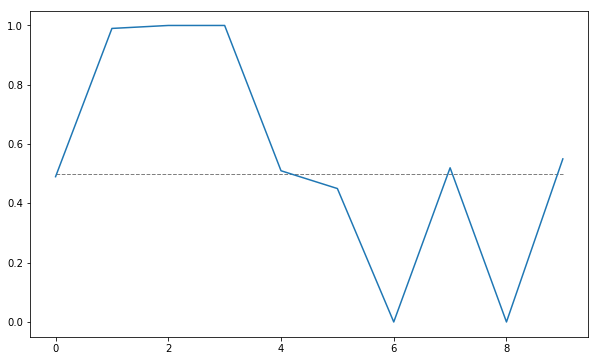

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(len(history)), [0.5]*len(history), linewidth=1, linestyle='--', color='grey')
plt.plot(range(len(history)), history);